## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language models (for decoder and encoder)

* or just fine-tunning BART/ELECTRA/... ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_to_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_to_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_to_data = './data.txt'

Dataset not found locally. Downloading from github.


SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = C:\Program Files (x86)\GnuWin32/etc/wgetrc
--2023-05-19 00:00:26--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Распознаётся raw.githubusercontent.com... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Устанавливается соединение с raw.githubusercontent.com|185.199.110.133|:443... соединение установлено.
OpenSSL: error:140770FC:SSL routines:SSL23_GET_SERVER_HELLO:unknown protocol
Невозможно установить соединение SSL.


In [2]:
path_to_data = './data.txt'

Baseline solution BLEU score is quite low. Try to achieve at least __21__ BLEU on the test set. 
The checkpoints are:

* __21__ - minimal score to submit the homework, 30% of points

* __25__ - good score, 70% of points

* __27__ - excellent score, 100% of points

### Warning! The code below is deeeeeeeply deprecated and is is provided only as simple guide.
We suggest you to stick to most recent pipelines here, e.g. by Huggingface: 
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

In [2]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k, multi30k
#from torchtext.data import Field, BucketIterator

#import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [5]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_to_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [6]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [7]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [8]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [9]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9267
Unique tokens in target (en) vocabulary: 6699


Here are tokens from original (RU) corpus:

In [10]:
SRC.vocab.itos[::1000]

['<unk>',
 '29',
 'соль',
 'комо',
 '―',
 'электрическая',
 'ming',
 'утренний',
 'детском',
 'таунус']

And from target (EN) corpus:

In [11]:
TRG.vocab.itos[::1000]

['<unk>', 'king', 'buffets', 'catch', 'media', 'schedule', 'maraunenhof']

And here is example from train dataset:

In [12]:
print(vars(train_data.examples[9]))

{'trg': ['laundry', 'service', 'is', 'provided', '.'], 'src': ['помимо', 'этого', ',', 'гостям', 'предоставляются', 'услуги', 'прачечной', '.']}


Let's check the length distributions:

Length distribution in Train data


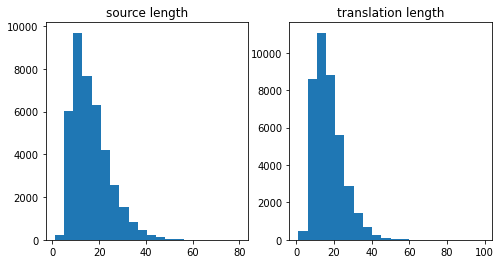

In [13]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


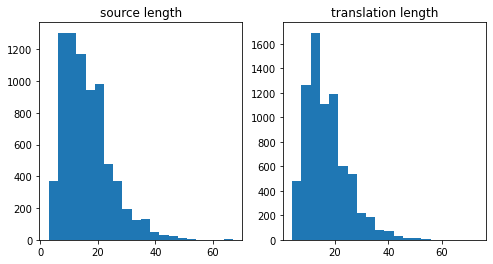

In [14]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
device

device(type='cuda', index=1)

In [21]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [22]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 55x128 (GPU 1)]
	[.src]:[torch.cuda.LongTensor of size 59x128 (GPU 1)]
torch.Size([59, 128]) torch.Size([55, 128])


In [23]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [24]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [25]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9267, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6699, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6699, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,880,299 trainable parameters


In [27]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [28]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [29]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [30]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [31]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

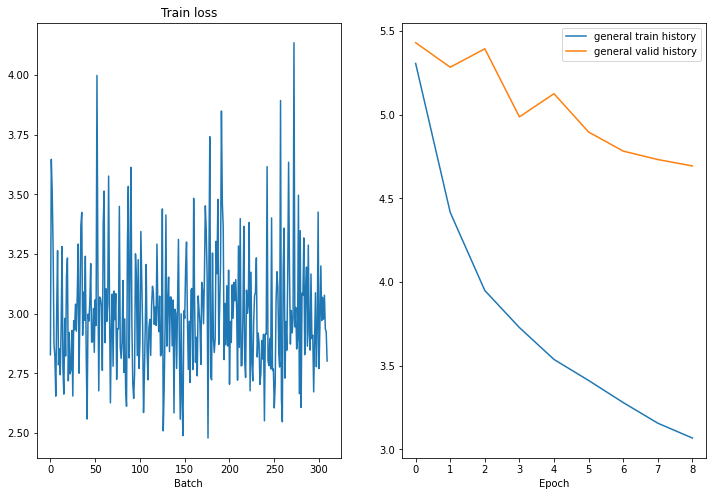

Epoch: 10 | Time: 1m 10s
	Train Loss: 2.998 | Train PPL:  20.040
	 Val. Loss: 4.710 |  Val. PPL: 111.007


In [32]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [104]:
del utils

In [105]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [106]:
batch = next(iter(test_iterator))

In [107]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: there is a 24 - hour front desk at the property .
Generated: the property offers a 24 - hour front desk . .

Original: this property also features free wifi .
Generated: free wifi access . . . .



In [108]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [109]:
import tqdm

In [110]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:03, 18.87it/s]


In [111]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

14.139920232081806

# ----------------------------------------------------------------------

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from IPython.display import clear_output
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import gc
from torch.nn.utils.rnn import pad_sequence
from nltk.translate.bleu_score import corpus_bleu
sns.set_style('darkgrid')
device = torch.device('cuda')

In [32]:
# # copied from https://raw.githubusercontent.com/yandexdataschool/nlp_course/2019/week04_seq2seq/utils.py
# class Vocab:
#     def __init__(self, tokens, bos="<BOS>", eos="<EOS>", unk='<UNK>'):
#         """
#         A special class that converts lines of tokens into matrices and backwards
#         """
#         assert all(tok in tokens for tok in (bos, eos, unk))
#         self.tokens = tokens
#         self.token_to_ix = {t:i for i, t in enumerate(tokens)}
#         self.bos, self.eos, self.unk = bos, eos, unk
#         self.bos_ix = self.token_to_ix[bos]
#         self.eos_ix = self.token_to_ix[eos]
#         self.unk_ix = self.token_to_ix[unk]

#     def __len__(self):
#         return len(self.tokens)

#     def from_lines(lines, bos="<BOS>", eos="<EOS>", unk='<UNK>'):
#         flat_lines = '\n'.join(list(lines)).split()
#         tokens = sorted(set(flat_lines))
#         tokens = [t for t in tokens if t not in (bos, eos, unk) and len(t)]
#         tokens = [bos, eos, unk] + tokens
#         return Vocab(tokens, bos, eos, unk)

#     def tokenize(self, string):
#         """converts string to a list of tokens"""
#         tokens = [tok if tok in self.token_to_ix else self.unk
#                   for tok in string.split()]
#         return [self.bos] + tokens + [self.eos]

#     def to_matrix(self, lines, max_len=None):
#         """
#         convert variable length token sequences into fixed size matrix
#         example usage:
#         >>>print( as_matrix(words[:3],source_to_ix))
#         [[15 22 21 28 27 13 -1 -1 -1 -1 -1]
#          [30 21 15 15 21 14 28 27 13 -1 -1]
#          [25 37 31 34 21 20 37 21 28 19 13]]
#         """
#         lines = list(map(self.tokenize, lines))
#         max_len = max_len or max(map(len, lines))

#         matrix = np.zeros((len(lines), max_len), dtype='int32') + self.eos_ix
#         for i, seq in enumerate(lines):
#             row_ix = list(map(self.token_to_ix.get, seq))[:max_len]
#             matrix[i, :len(row_ix)] = row_ix

#         return matrix

#     def to_lines(self, matrix, crop=True):
#         """
#         Convert matrix of token ids into strings
#         :param matrix: matrix of tokens of int32, shape=[batch,time]
#         :param crop: if True, crops BOS and EOS from line
#         :return:
#         """
#         lines = []
#         for line_ix in map(list,matrix):
#             if crop:
#                 if line_ix[0] == self.bos_ix:
#                     line_ix = line_ix[1:]
#                 if self.eos_ix in line_ix:
#                     line_ix = line_ix[:line_ix.index(self.eos_ix)]
#             line = ' '.join(self.tokens[i] for i in line_ix)
#             lines.append(line)
#         return lines

In [33]:
# tokenizer = WordPunctTokenizer()
# def tokenize(x):
#     return ' '.join(tokenizer.tokenize(x.lower()))

# data = pd.read_csv("./data.tsv", sep="\t", header=None).values

# with open('train_en', 'w', encoding="utf8") as f_src,  open('train_ru', 'w', encoding="utf8") as f_dst:
#     for line in data:
#         f_src.write(tokenize(line[0]) + '\n')
#         f_dst.write(tokenize(line[1]) + '\n')

In [34]:
# bpe = {}
# for lang in ['en', 'ru']:
#     learn_bpe(open(f'train_{lang}', 'r', encoding="utf8"), open(f'bpe_rules_{lang}', 'w', encoding="utf8"), num_symbols=5000)
#     bpe[lang] = BPE(open(f'bpe_rules_{lang}', 'r', encoding="utf8"))
    
#     with open(f'train.bpe_{lang}', 'w', encoding="utf8") as f_out:
#         for line in open(f'train_{lang}', 'r', encoding="utf8"):
#             f_out.write(bpe[lang].process_line(line.strip()) + '\n')

In [35]:
# data_inp = np.array(open('./train.bpe_ru', encoding="utf8").read().split('\n'))
# data_out = np.array(open('./train.bpe_en', encoding="utf8").read().split('\n'))

In [36]:
# from sklearn.model_selection import train_test_split
# train_inp, val_inp, train_out, val_out = train_test_split(data_inp, data_out, test_size=2500,
#                                                           random_state=42)

In [3]:
# inp_voc = Vocab.from_lines(train_inp)
# out_voc = Vocab.from_lines(train_out)

In [3]:
class MyDataset(Dataset):
    def __init__(self, path_src, path_trg, 
                 tokenizer_eng=None, tokenizer_ru=None):
        
        with open(path_src, 'r', encoding="utf8") as f_src,  open(path_trg, 'r', encoding="utf8") as f_trg:
            self.src = f_src.readlines()
            self.trg = f_trg.readlines()

        if tokenizer_eng is not None:
            self.src = tokenizer_eng(self.src, padding=True)
        if tokenizer_ru is not None:
            self.trg = tokenizer_ru(self.trg, padding=True)
            
    def __len__(self):
        return len(self.src)
    
    def __getitem__(self, index):
        return torch.tensor(self.src[index]), torch.tensor(self.trg[index])

### Roberta + RNN-decoder

In [4]:
from transformers import RobertaModel, RobertaTokenizer, AutoTokenizer

roberta = RobertaModel.from_pretrained("roberta-base")
roberta.to(device)
roberta.eval()

rb_tokenizer_eng = RobertaTokenizer.from_pretrained("roberta-base")
rb_tokenizer_ru = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

In [191]:
def roberta_tokenizer_eng(data, padding=False):
    return rb_tokenizer_eng(data, padding=padding)['input_ids']
def roberta_tokenizer_ru(data, padding=False):
    return rb_tokenizer_ru(data, padding=padding)['input_ids']

tr_roberta_dataset = MyDataset('train_en', 'train_ru', 
                               roberta_tokenizer_eng, roberta_tokenizer_ru)
train_roberta_dataset, val_roberta_dataset, test_roberta_dataset = random_split(tr_roberta_dataset, [0.8, 0.15, 0.05])

In [193]:
batch_size = 32

train_loader_roberta = DataLoader(train_roberta_dataset, batch_size, 
                                shuffle=True)
val_loader_roberta = DataLoader(val_roberta_dataset, batch_size)
test_loader_roberta = DataLoader(test_roberta_dataset, batch_size)

In [196]:
torch.cuda.empty_cache()

roberta_enc_generated_out = []
roberta_enc_true_out = []
roberta_enc_generated_out_val = []
roberta_enc_true_out_val = []
roberta_enc_generated_out_test = []
roberta_enc_true_out_test = []

for tr_eng, tr_ru in tqdm(train_loader_roberta, leave=False, desc=f"Iterations", colour="#005500"):
#for i in tqdm(rand_perm_ind, leave=False, desc=f"Iterations", colour="#005500"):
    
    #tr_eng, tr_ru = train_roberta_dataset[i]
    tr_eng, tr_ru = tr_eng.to(device), tr_ru.to(device)
    
    attention_mask = (tr_eng != 1).int()  
    
    roberta_enc_generated_out.append(roberta(tr_eng, 
                        attention_mask=attention_mask)[0].detach().to("cpu"))
    roberta_enc_true_out.append(tr_ru.detach().to("cpu"))

for tr_eng, tr_ru in tqdm(val_loader_roberta, leave=False, desc=f"Iterations", colour="#005500"):

    tr_eng, tr_ru = tr_eng.to(device), tr_ru.to(device)
    
    attention_mask = (tr_eng != 1).int()  
    
    roberta_enc_generated_out_val.append(roberta(tr_eng, 
                        attention_mask=attention_mask)[0].detach().to("cpu"))
    roberta_enc_true_out_val.append(tr_ru.detach().to("cpu"))  
      
for tr_eng, tr_ru in tqdm(test_loader_roberta, leave=False, desc=f"Iterations", colour="#005500"):

    tr_eng, tr_ru = tr_eng.to(device), tr_ru.to(device)
    
    attention_mask = (tr_eng != 1).int()  
    
    roberta_enc_generated_out_test.append(roberta(tr_eng, 
                        attention_mask=attention_mask)[0].detach().to("cpu"))
    roberta_enc_true_out_test.append(tr_ru.detach().to("cpu"))  
    
    
roberta_enc_generated_out = torch.cat(roberta_enc_generated_out)
roberta_enc_true_out = torch.cat(roberta_enc_true_out)
roberta_enc_generated_out_val = torch.cat(roberta_enc_generated_out_val)
roberta_enc_true_out_val = torch.cat(roberta_enc_true_out_val)    
roberta_enc_generated_out_test = torch.cat(roberta_enc_generated_out_test)
roberta_enc_true_out_test = torch.cat(roberta_enc_true_out_test)   

Iterations:   0%|          | 0/1250 [00:00<?, ?it/s]

Iterations:   0%|          | 0/235 [00:00<?, ?it/s]

Iterations:   0%|          | 0/79 [00:00<?, ?it/s]

In [5]:
# torch.save(roberta_enc_generated_out, "roberta_enc_generated_out.pt")
# torch.save(roberta_enc_true_out, "roberta_enc_true_out.pt")
# torch.save(roberta_enc_generated_out_val, "roberta_enc_generated_out_val.pt")
# torch.save(roberta_enc_true_out_val, "roberta_enc_true_out_val.pt")
# torch.save(roberta_enc_generated_out_test, "roberta_enc_generated_out_test.pt")
# torch.save(roberta_enc_true_out_test, "roberta_enc_true_out_test.pt")

# roberta_enc_generated_out = torch.load("roberta_enc_generated_out.pt")
# roberta_enc_true_out = torch.load("roberta_enc_true_out.pt")
# roberta_enc_generated_out_val = torch.load("roberta_enc_generated_out_val.pt")
# roberta_enc_true_out_val = torch.load("roberta_enc_true_out_val.pt") 
# roberta_enc_generated_out_test = torch.load("roberta_enc_generated_out_test.pt")
# roberta_enc_true_out_test = torch.load("roberta_enc_true_out_test.pt") 

In [5]:
class LSTM_Decoder(nn.Module):
    def __init__(self, input_size, 
                 vocab_size, 
                 hidden_size=1024, 
                 num_layers=3,
                 dropout=0,
                 bidirectional=False):
        super(self.__class__, self).__init__()
        
        self.input_size = input_size
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.LSTM(input_size=input_size, 
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True,
                           dropout=dropout,
                           bidirectional=bidirectional)
        
        self.mult = 2 if bidirectional else 1
        self.out = nn.Linear(hidden_size*self.mult, vocab_size)
        self.hidden_size = hidden_size
        
    def forward(self, x):
        out, (h_n, c_n)  = self.rnn(x)
        next_logits = self.out(out)        
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

In [6]:
class LSTM_loss():
    def __init__(self, vocab_size, ignore_index=None):
        self.vocab_size = vocab_size
        self.ignore_index = ignore_index
        
    def __call__(self, pred, target):
        
        pred_shifted = pred[:, :-1].contiguous().view(-1, self.vocab_size)
        target_shifted = target[:, 1:].contiguous().view(-1)
        
        return F.nll_loss(pred_shifted, target_shifted, 
                        ignore_index=self.ignore_index)

In [6]:
def evaluate(model, val_loader, loss):
    model.eval()
    with torch.no_grad():

        loss_accum = 0

        for i_step, (x, y) in enumerate(val_loader):
            x, y = x.cuda(), y.cuda()

            prediction = model(x)    
            loss_value = loss(prediction, y).detach().cpu()
            loss_accum += loss_value

        ave_loss = loss_accum / i_step

    gc.collect()
    torch.cuda.empty_cache()
    
    return ave_loss


def train_model(model, train_loader, val_loader, 
                loss, optimizer, num_epochs,
                scheduler=None,
                store_path=None,
                teacher_forcing=False):    
    train_loss = []
    val_loss = []
    loss_by_iter = []
    
    for epoch in tqdm(range(num_epochs), desc=f"Training progress", colour="#00ff00"):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model.train()
        
        loss_accum = 0
        
        for i_step, (x, y) in enumerate(tqdm(train_loader, leave=False, 
                 desc=f"Epoch {epoch + 1}/{num_epochs}", colour="#005500")):
            
            model.zero_grad()
            x, y = x.cuda(), y.cuda()
            
            if teacher_forcing:
                prediction = model(x, y, p=1-epoch/num_epochs)
            else:
                prediction = model(x)    
                
            loss_value = loss(prediction, y)

            loss_value.backward()
            optimizer.step()

            loss_accum += loss_value.detach().cpu()
            
            loss_by_iter.append(loss_value.detach().cpu())
            
            if (i_step + 1) % 100 == 0:
                if scheduler is not None:
                    scheduler.step()
                    
                clear_output(True)
                fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
                plot_progress(loss_by_iter, ax=axes[0])
                
                if len(val_loss) > 0:
                    plot_results(train_loss, val_loss, ax=axes[1])
                plt.show()        
            
        gc.collect()
        torch.cuda.empty_cache()
            
        ave_loss = loss_accum / i_step  
        train_loss.append(float(ave_loss))
        val_loss.append(float(evaluate(model, val_loader, loss)))
        
        clear_output(True)
        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
        plot_progress(loss_by_iter, ax=axes[0])
        plot_results(train_loss, val_loss, ax=axes[1])
        plt.show()
        
        if store_path is not None:
            torch.save(model.state_dict(), store_path)
        
    return train_loss, val_loss


def plot_results(train_loss, val_loss, ax=None):
    if ax is None:
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 8))
    
    ax.plot(train_loss, lw=3, color=sns.color_palette()[0],
            label="Train loss")
    ax.plot(val_loss, lw=3, color=sns.color_palette()[1],
            label="Validation loss")

    ax.set_xlabel('Epoch', fontsize=18)
    ax.set_ylabel('Loss', fontsize=18)
    ax.set_title("Average loss", fontsize=20)
    
    ax.tick_params(axis='both', labelsize=16)
    ax.legend(shadow = True, fontsize=18, loc='upper left')  
    
    
def plot_progress(loss, ax=None):
    if ax is None:
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 8))
    
    ax.plot(np.arange(len(loss)), loss, lw=3, 
            color=sns.color_palette()[0],)

    ax.set_xlabel('Iterations', fontsize=18)
    ax.set_ylabel('Loss', fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    
    ax.set_title("Loss on train", fontsize=20)
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

In [7]:
class DecoderDataset(Dataset):
    def __init__(self, src, trg):
        self.src = src
        self.trg = trg
        src_len = src.shape[1]
        trg_len = trg.shape[1]
        if src_len > trg_len:
            self.trg = torch.cat([self.trg, 
                    torch.zeros((trg.shape[0], src_len-trg_len))], dim=1)
        else:
            self.src = torch.cat([self.src,
            torch.zeros((src.shape[0], trg_len-src_len, src.shape[2]))], dim=1)
            
    def __len__(self):
        return len(self.src)
    
    def __getitem__(self, index):
        return torch.tensor(self.src[index]), torch.tensor(self.trg[index], dtype=int)

In [8]:
train_roberta_decoder_dataset = DecoderDataset(roberta_enc_generated_out,
                                              roberta_enc_true_out)
train_roberta_decoder_loader = DataLoader(train_roberta_decoder_dataset,
                                         batch_size=4, shuffle=True)

val_roberta_decoder_dataset = DecoderDataset(roberta_enc_generated_out_val,
                                              roberta_enc_true_out_val)
val_roberta_decoder_loader = DataLoader(val_roberta_decoder_dataset,
                                         batch_size=4, shuffle=True)

test_roberta_decoder_dataset = DecoderDataset(roberta_enc_generated_out_test,
                                              roberta_enc_true_out_test)
test_roberta_decoder_loader = DataLoader(test_roberta_decoder_dataset,
                                         batch_size=1, shuffle=True)

In [9]:
from CustomizableCosineDecayScheduler import CosineDecayWithWarmUpScheduler as CosScheduler

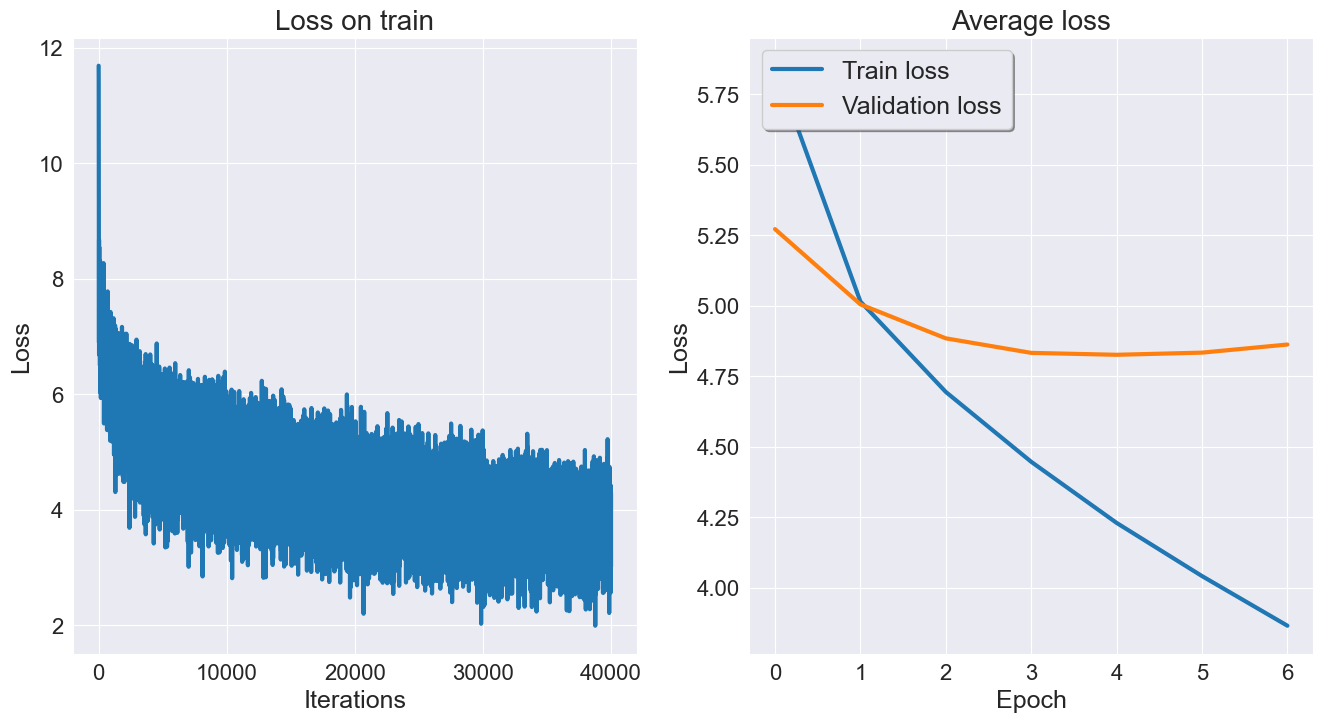

KeyboardInterrupt: 

In [290]:
try:
    del lstm_decoder
except:
    pass

gc.collect()
torch.cuda.empty_cache()

lstm_decoder = LSTM_Decoder(input_size=768, 
                 vocab_size=rb_tokenizer_ru.vocab_size, 
                 hidden_size=256, 
                 num_layers=3,
                 dropout=0.25,
                 bidirectional=True).to(device)

lstm_optimizer = torch.optim.Adam(lstm_decoder.parameters(), lr=5e-4)
lstm_loss = LSTM_loss(rb_tokenizer_ru.vocab_size, ignore_index=0)

lstm_scheduler = CosScheduler(lstm_optimizer, 
                 max_lr=5e-4, min_lr=3e-6, num_step_down=20*50, 
                    num_step_up=0, gamma=0.5, alpha=0.3)

roberta_decoder_train_loss, roberta_decoder_val_loss = train_model(
            lstm_decoder, train_roberta_decoder_loader,
            val_roberta_decoder_loader,
            lstm_loss, lstm_optimizer, 
            num_epochs=20, scheduler=lstm_scheduler,
            store_path="LSTM_Decoder.pt")

In [116]:
def get_text(batch, tokenizer):
    no_specials = list(map(lambda string: list(filter(lambda x: x not in tokenizer.all_special_ids, string)), 
                           batch))
    
    return tokenizer.batch_decode(no_specials)

In [292]:
original_text = []
generated_text = []
lstm_decoder.eval()

with torch.no_grad():
    for i, (src, trg) in enumerate(tqdm(test_roberta_decoder_loader, 
                    leave=False, desc="Batches", colour="#005500")):
        
        src, trg = src.cuda(), trg.cuda()

        output = lstm_decoder(src).detach().cpu()

        output = output.argmax(dim=-1)
        
        original_text.extend(get_text(trg, rb_tokenizer_ru))
        generated_text.extend(get_text(output, rb_tokenizer_ru))


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

C:\Users\Nikita\AppData\Local\Temp\ipykernel_119080\1165225325.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.src[index]), torch.tensor(self.trg[index], dtype=int)


In [293]:
roberta_lstm_decoder_score = corpus_bleu([[text] for text in original_text], generated_text) * 100
print(roberta_lstm_decoder_score)

36.39845971401781


## LSTM + attention decoder for Roberta encoder

In [10]:
class WAttention(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.W = nn.Linear(input_size, hidden_size)
        self.down = nn.Linear(hidden_size + input_size, hidden_size)
        
    def forward(self, x, h):
        weights = F.softmax(torch.sum(self.W(x).unsqueeze(0) * h.unsqueeze(2), dim=-1), dim=-1)
        out = torch.cat([torch.sum(weights.unsqueeze(-1) * x.unsqueeze(0), dim=2), h], dim=-1)
        out = self.down(out)
        return out
    

class LSTM_Attention_loss():
    def __init__(self, vocab_size, ignore_index=None):
        self.vocab_size = vocab_size
        self.ignore_index = ignore_index
        
    def __call__(self, pred, target):
        
        pred_shifted = pred.contiguous().view(-1, self.vocab_size)

        target_shifted = target[:, 1:].contiguous().view(-1)
        
        return F.nll_loss(pred_shifted, target_shifted, 
                        ignore_index=self.ignore_index)
    

class LSTM_Attention_Decoder(nn.Module):
    def __init__(self, input_size, 
                 vocab_size, 
                 tokenizer,
                 hidden_size=128, 
                 num_layers=2,
                 dropout=0,
                 emb_size=256,
                 bidirectional=False):
        
        super(self.__class__, self).__init__()
        
        self.input_size = input_size
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.tokenizer = tokenizer
        
        self.emb = nn.Embedding(vocab_size, emb_size)
        
        self.attention = WAttention(input_size, hidden_size)
        
        self.rnn = nn.LSTM(input_size=emb_size, 
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True,
                           dropout=dropout,
                           bidirectional=bidirectional)
        
        self.mult = 2 if bidirectional else 1
        self.linear = nn.Linear(hidden_size*self.mult, vocab_size)
        self.hidden_size = hidden_size

        
    def forward(self, x, y=None, p=0):
        
        seq = [torch.empty(x.shape[0], 1).fill_(self.tokenizer.cls_token_id).int().to(device)]
        logps = []
        inp_len = x.shape[1]
        
        h_n = torch.zeros((self.num_layers, x.shape[0], self.hidden_size)).to(device)
        c_n = torch.zeros((self.num_layers, x.shape[0], self.hidden_size)).to(device)
        h_n = self.attention(x, h_n)
        c_n = self.attention(x, c_n)
        
        out, (h_n, c_n) = self.rnn(self.emb(seq[-1].to(device)), (h_n, c_n))
        next_logp = F.log_softmax(self.linear(out), dim=-1)
        logps.append(next_logp)
        seq.append(torch.argmax(next_logp, dim=-1))  
        
        max_len = inp_len if y is None else y.shape[1]
        it = 0
        
        while len(seq) < max_len:
            it += 1
            h_n = self.attention(x, h_n)
            
            if (y is None) or np.random.binomial(1, 1-p):
                out, (h_n, c_n) = self.rnn(self.emb(seq[-1].to(device)),
                                          (h_n, c_n))
            else:
                out, (h_n, c_n) = self.rnn(self.emb(y[:,it].unsqueeze(1)),
                                          (h_n, c_n))
                
            next_logp = F.log_softmax(self.linear(out), dim=-1)
            logps.append(next_logp)
            seq.append(torch.argmax(next_logp, dim=-1))
        
        return torch.cat(logps, dim=1)
    
    def generate(self, x):
        
        seq = [torch.empty(x.shape[0], 1).fill_(self.tokenizer.cls_token_id).int()]
        inp_len = x.shape[1]
        
        h_n = torch.zeros((self.num_layers, x.shape[0], self.hidden_size)).to(device)
        c_n = torch.zeros((self.num_layers, x.shape[0], self.hidden_size)).to(device)
        h_n = self.attention(x, h_n)
        c_n = self.attention(x, c_n)
        
        out, (h_n, c_n) = self.rnn(self.emb(seq[-1].to(device)), (h_n, c_n))
        next_logp = F.log_softmax(self.linear(out), dim=-1)
        seq.append(torch.argmax(next_logp, dim=-1).detach().cpu())
        
        while (len(seq) < inp_len*2) and (seq[-1] != self.tokenizer.sep_token_id):
            h_n = self.attention(x, h_n)
            
            out, (h_n, c_n) = self.rnn(self.emb(seq[-1].to(device)),
                                      (h_n, c_n))
            next_logp = F.log_softmax(self.linear(out), dim=-1)
            seq.append(torch.argmax(next_logp, dim=-1).detach().cpu())
        
        return seq

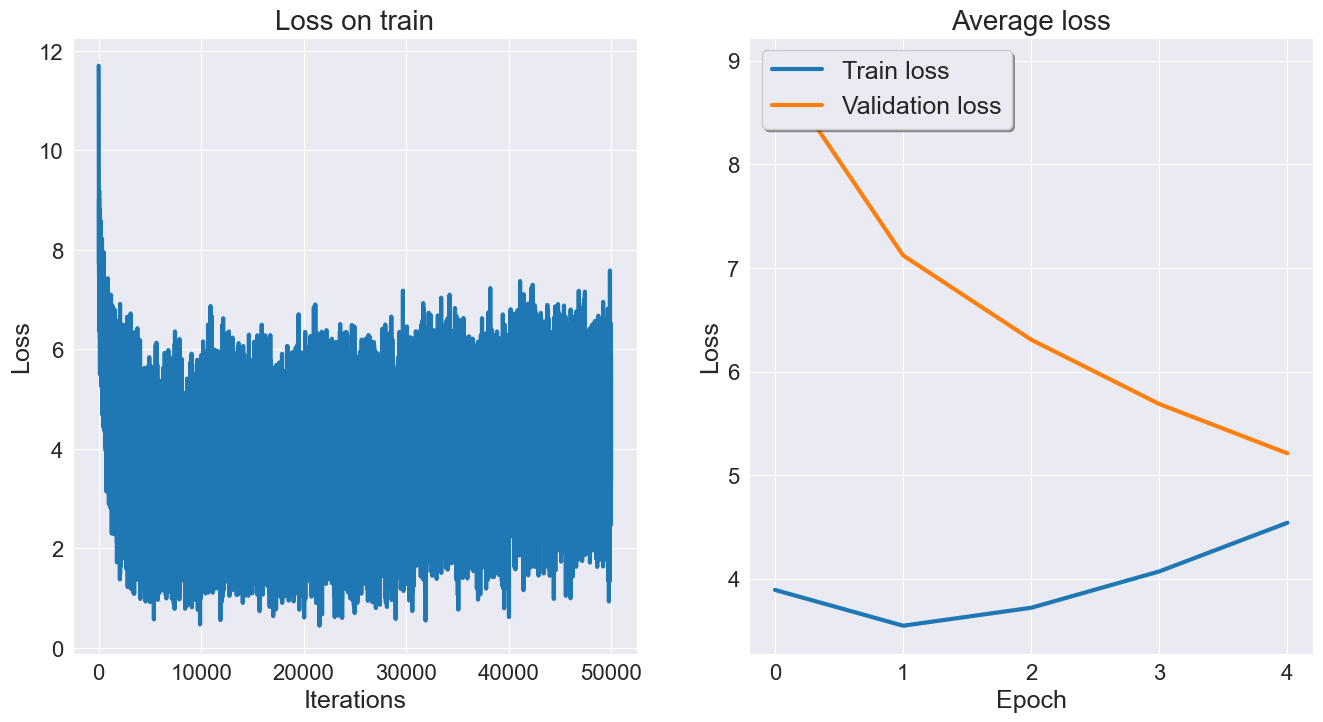

In [11]:
try:
    del lstm_attention_decoder
except:
    pass

gc.collect()
torch.cuda.empty_cache()


lstm_attention_decoder = LSTM_Attention_Decoder(input_size=768, 
                             vocab_size=rb_tokenizer_ru.vocab_size, 
                             tokenizer=rb_tokenizer_ru,                               
                             hidden_size=384, 
                             num_layers=2,
                             dropout=0.1,
                             emb_size=768,
                             bidirectional=False).to(device)

lstm_attention_optimizer = torch.optim.Adam(lstm_attention_decoder.parameters(),
                                            lr=5e-4, betas=(0.92, 0.99))

lstm_attention_loss = LSTM_Attention_loss(rb_tokenizer_ru.vocab_size,
                                          ignore_index=0)

lstm_attention_scheduler = CosScheduler(lstm_attention_optimizer, 
                 max_lr=5e-4, min_lr=3e-6, num_step_down=100, 
                    num_step_up=0, gamma=0.7, alpha=0.3)

roberta_decoder_attention_train_loss, roberta_decoder_attention_val_loss = train_model(
            lstm_attention_decoder, train_roberta_decoder_loader,
            val_roberta_decoder_loader,
            lstm_attention_loss, lstm_attention_optimizer, 
            num_epochs=5, scheduler=lstm_attention_scheduler,
            store_path="LSTM_Attention_Decoder.pt",
            teacher_forcing=True)
gc.collect()
torch.cuda.empty_cache()

#### loss идущий вверх -- это нормально, с эпохами уменьшается шанс подсунуть модели правильное слово, вместо только что сгенерированного.

In [12]:
def get_text_att(string, tokenizer):

    no_specials = list(filter(lambda x: x not in tokenizer.all_special_ids, string))
    
    return tokenizer.decode(no_specials)

In [13]:
original_text = []
generated_text = []
lstm_attention_decoder.eval()

with torch.no_grad():
    for i, (src, trg) in enumerate(tqdm(test_roberta_decoder_loader, 
                    leave=False, desc="Batches", colour="#005500")):
        
        src, trg = src.cuda(), trg.cuda()

        output = lstm_attention_decoder.generate(src)
        output = [x.squeeze() for x in output]
        
        original_text.append(get_text_att(trg.squeeze(), rb_tokenizer_ru))
        generated_text.append(get_text_att(output, rb_tokenizer_ru))


Batches:   0%|          | 0/2500 [00:00<?, ?it/s]

C:\Users\Nikita\AppData\Local\Temp\ipykernel_315196\1165225325.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.src[index]), torch.tensor(self.trg[index], dtype=int)


In [15]:
generated_text

['в всех апартаментах апартаментовентовентовентов мини - кухня с мини - кухня с холодильником, холодильником, холодильником иом.',
 'отель отель « постель » расположен в городе бесплатным wi - fi.',
 'к услугам гостей бесплатный континентальный завтрак и бесплатный wi - fi.',
 'гости могут пользоваться бесплатным wi - fi.',
 'в распоряжении гостейств бесплатная частная парковка.',
 'номера располагают собственной ванной комнатой, телевизором иом и и и.',
 'отель от « « и » » 3, 5 км, км от отеля, а до а до — — 10 минут.',
 'в апартаментахентах с полностью оборудованной кухней с телевизором с плоским экраном и кабельными каналами, а также гостин гостиный уголок с диваном.',
 'до центра центра города города можно 10 минут. 10 минут.',
 'гости могут посетить посетить посетить музей « « в - в - в, в, в, в,..',
 'по утрам в отеле laaaa серв сервируют завтрак завтрак завтрак, а в в сервируется завтрак.',
 'отель отельaa находится в в метрах от от от - - - - - и в и в и в 800 метрах от междун

In [14]:
roberta_lstm_attention_decoder_score = corpus_bleu([[text] for text in original_text], generated_text) * 100
print(roberta_lstm_attention_decoder_score)

42.21539073318576
